In [144]:
%load_ext autoreload
%autoreload 2

# %load_ext rpy2.ipython
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import networkx as nx
import copy
import sys
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from glob import glob
import seaborn as sns
from IPython.display import display
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
# %config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

In [146]:
from bioreactor.plotting import *
from bioreactor.use_colors import *
from bioreactor.utils import *
from bioreactor.mutations import *
from bioreactor.clustering import *
from bioreactor.cells import *
from bioreactor.graphs import *
from bioreactor.annotation import *
from bioreactor.expression import *
from bioreactor.gsea import *
from bioreactor.ssgsea import *
from bioreactor.pathway_scoring import *
from bioreactor.lollipop import lollipop_plot, gc_content_plot
from bioreactor.survival import simple_multivar_cox_reg
from bioreactor.hla import *
from bioreactor.oncoplot2 import *
from bioreactor.cna import *

In [147]:
datasets_annotation = read_dataset('../DATA/Patients/datasets_annotation.tsv')

In [148]:
sign_gmts = read_gene_sets('./Signatures/mined.gmt')

In [149]:
datasets = ['GSE5851', 'GSE33072', 'GSE37138', 'GSE65021', 'GSE76360','GSE47994', 'GSE55348', 'GSE62327', 'GSE58984']

In [150]:
ann_paths_d = {'GSE5851': '../DATA/Patients/GSE5851/GSE5851_annotation.txt', 
               'GSE33072': '../DATA/Patients/GSE33072/GSE33072_annotation.tsv', 
               'GSE37138': '../DATA/Patients/GSE37138/GSE37138_annotation.tsv', 
               'GSE65021': '../DATA/Patients/GSE65021/GSE65021_annotation.tsv', 
               'GSE76360': '../DATA/Patients/GSE76360/GSE76360_annotation.tsv',
                'GSE47994': '../DATA/Patients/GSE47994/GSE47994_annotation.tsv',
                'GSE55348': '../DATA/Patients/GSE55348/GSE55348_annotation.tsv',
                 'GSE62327': '../DATA/Patients/GSE62327/GSE62327_annotation.tsv', 
                 'GSE58984':  '../DATA/Patients/GSE58984/GSE58984_annotation.tsv', }

exp_paths_d = {'GSE5851': '../DATA/Patients/GSE5851/GSE5851_GPL571_max_gs_samples.tsv',
               'GSE33072': '../DATA/Patients/GSE33072/GSE33072_GPL6244_max_gs_samples.tsv', 
               'GSE37138': '../DATA/Patients/GSE37138/GSE37138_GPL5188_med_gs_samples.tsv', 
               'GSE65021': '../DATA/Patients/GSE65021/GSE65021_GPL14951_maximal_gs_samples.tsv', 
               'GSE76360': '../DATA/Patients/GSE76360/GSE76360_GPL6947_max_gs_samples.tsv',
               'GSE47994': '../DATA/Patients/GSE47994/GSE47994_GPL13667_max_gs_samples.tsv',
               'GSE55348': '../DATA/Patients/GSE55348/GSE55348_GPL14951_max_gs_samples.tsv',
               'GSE62327': '../DATA/Patients/GSE62327/GSE62327_GPL14951_max_gs_samples.tsv',
                 'GSE58984':  '../DATA/Patients/GSE58984/GSE58984_GPL570_max_gs_samples.tsv',}

GSE5851


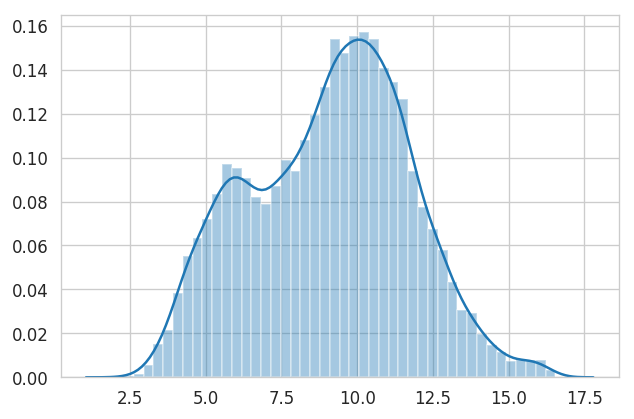

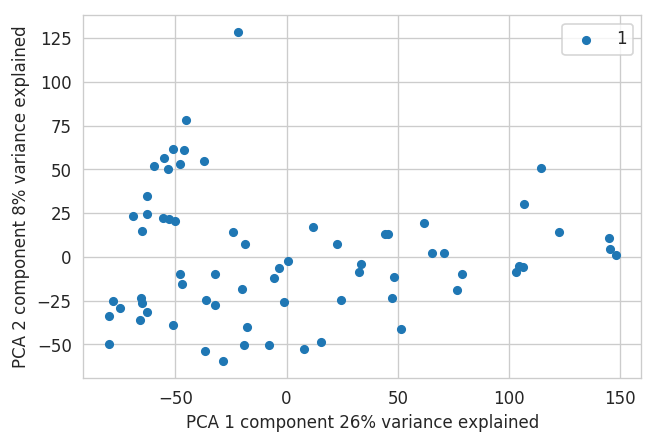

GSE33072


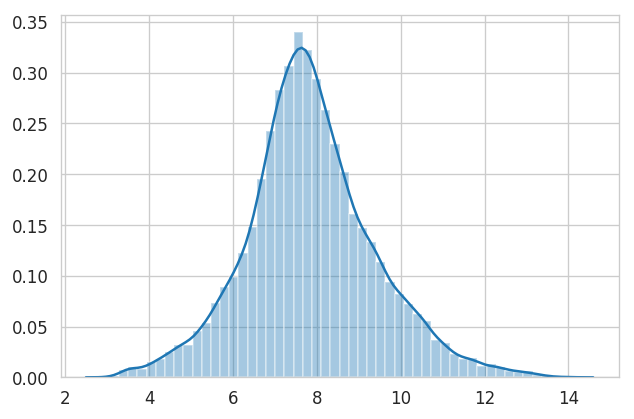

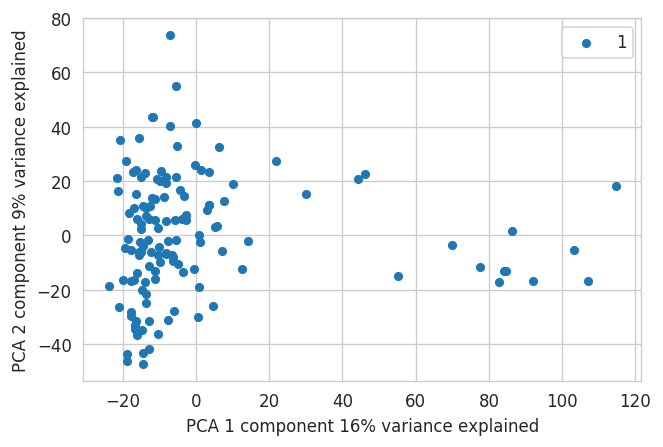

GSE37138


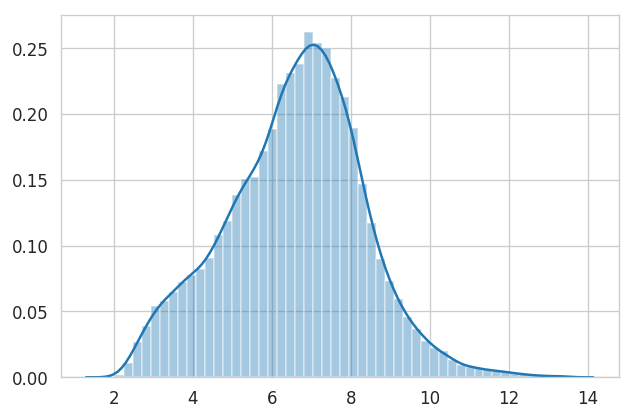

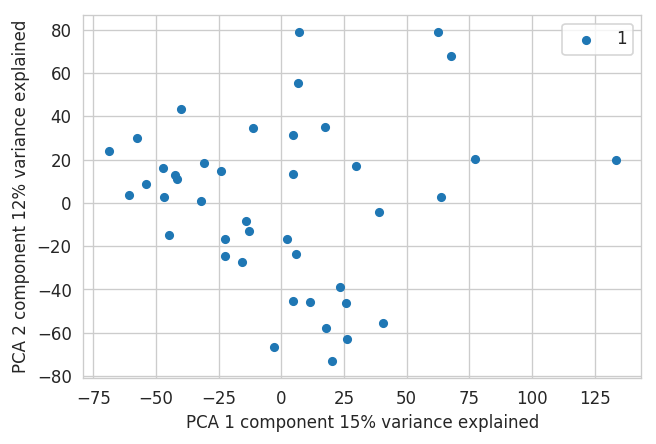

GSE65021


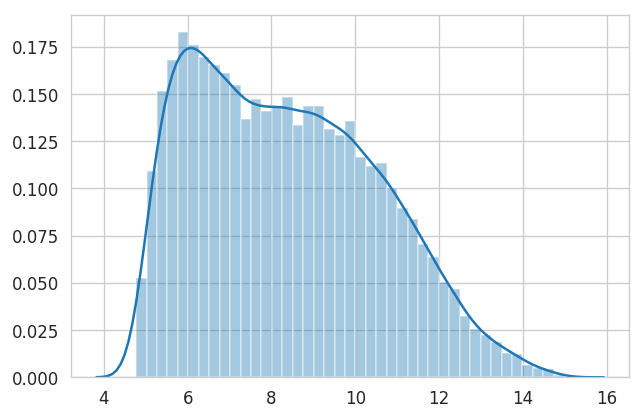

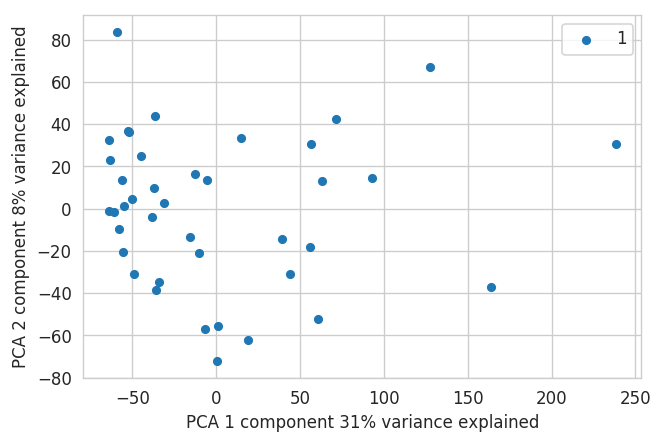

GSE76360


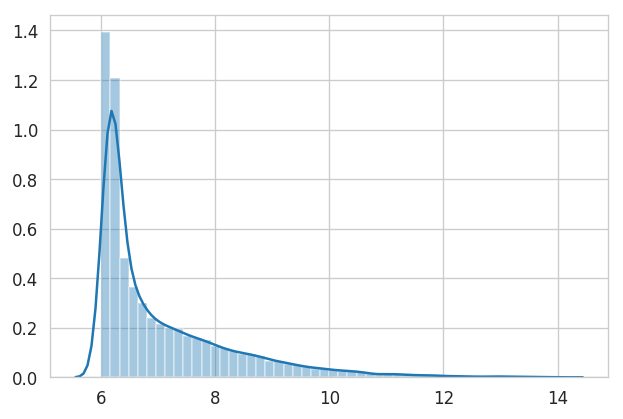

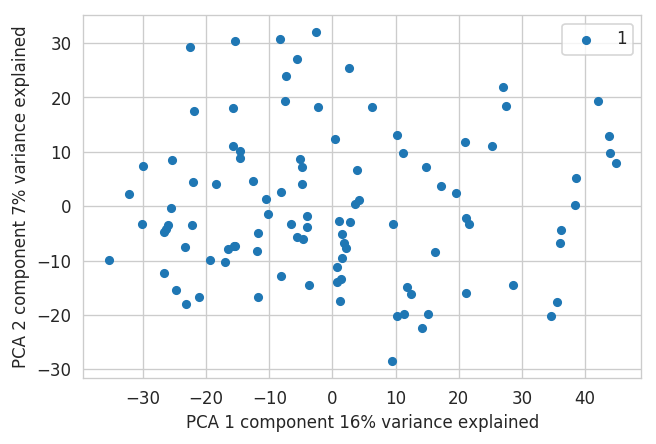

GSE47994


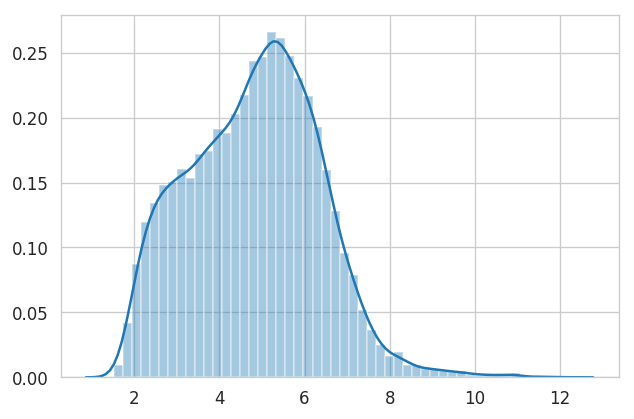

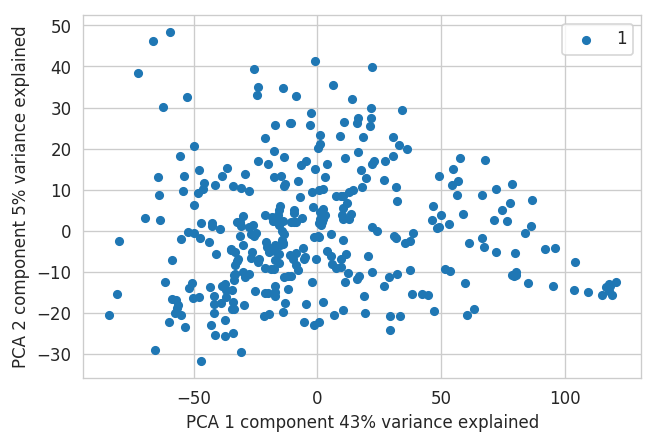

GSE55348


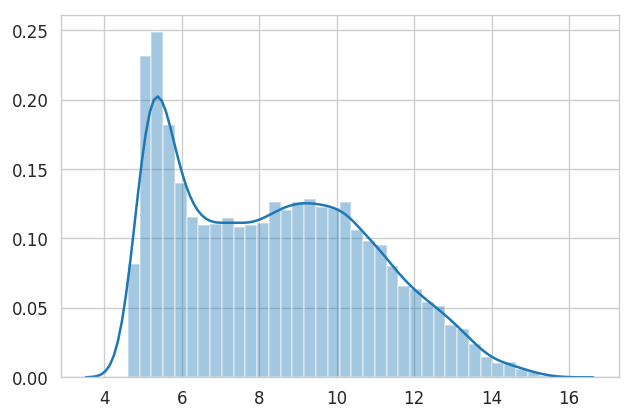

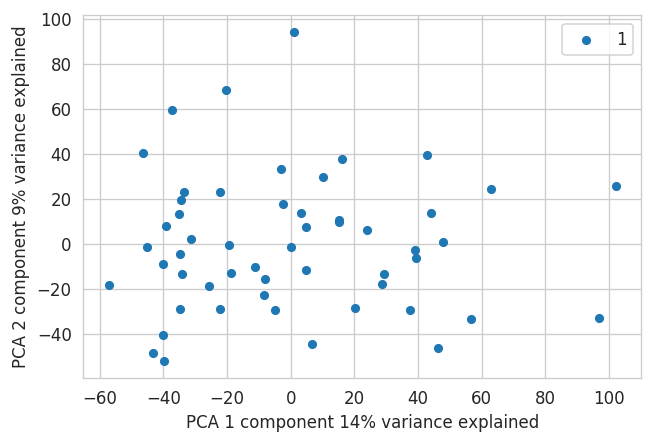

GSE62327


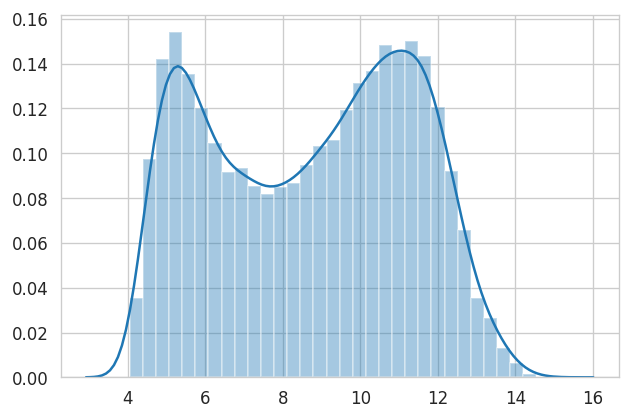

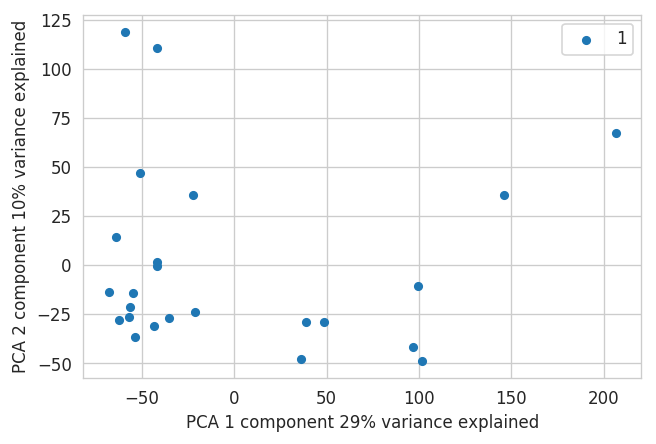

GSE58984


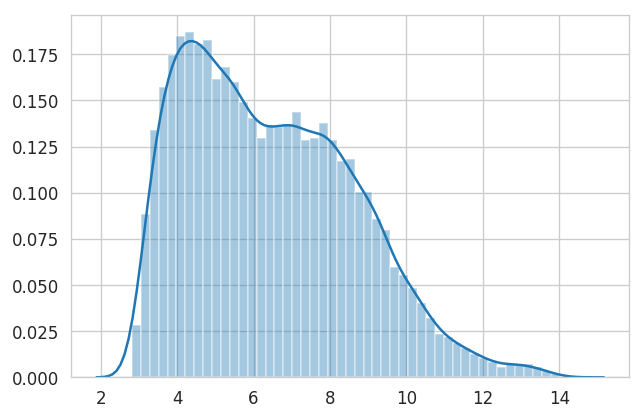

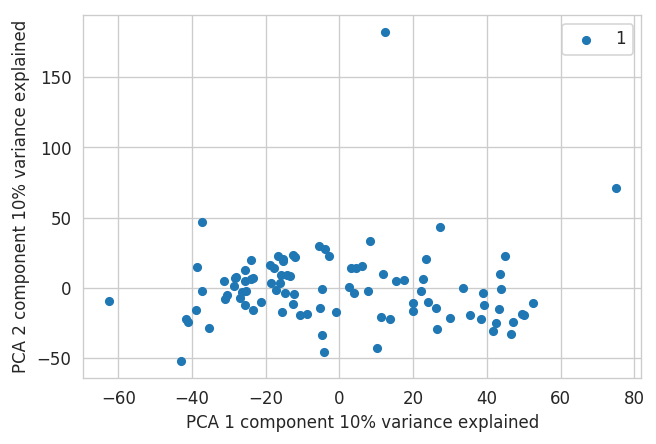

In [151]:
ann_d = {}
exp_d = {}
progeny_d = {}
signs = {}


for cds in datasets:
    print(cds)
    ann =  read_dataset(ann_paths_d[cds])
    cgenes =  read_dataset(exp_paths_d[cds]).T
    if cgenes.mean().mean() > 30:
        cgenes = np.log2(cgenes+1)
        
    common_samples = cgenes.index & ann.index
    
    ann_d[cds] = ann.loc[common_samples]
    exp_d[cds] = cgenes.loc[common_samples]
    
    sns.distplot(exp_d[cds].mean())
    plt.show()
    pca_plot(exp_d[cds], exp_d[cds].index.value_counts())
    plt.show()
    
    progeny = run_progeny(exp_d[cds].T)
    progeny.index = progeny.index.str.replace('.', '-')
    progeny_sc = median_scale(progeny, 4)
    
    progeny_d[cds] = progeny_sc.copy()
    
    signs[cds] = median_scale(ssgsea_formula(exp_d[cds].T, sign_gmts).T, 2)
    

GSE5851 COREAD Cetuximab (68, 23)


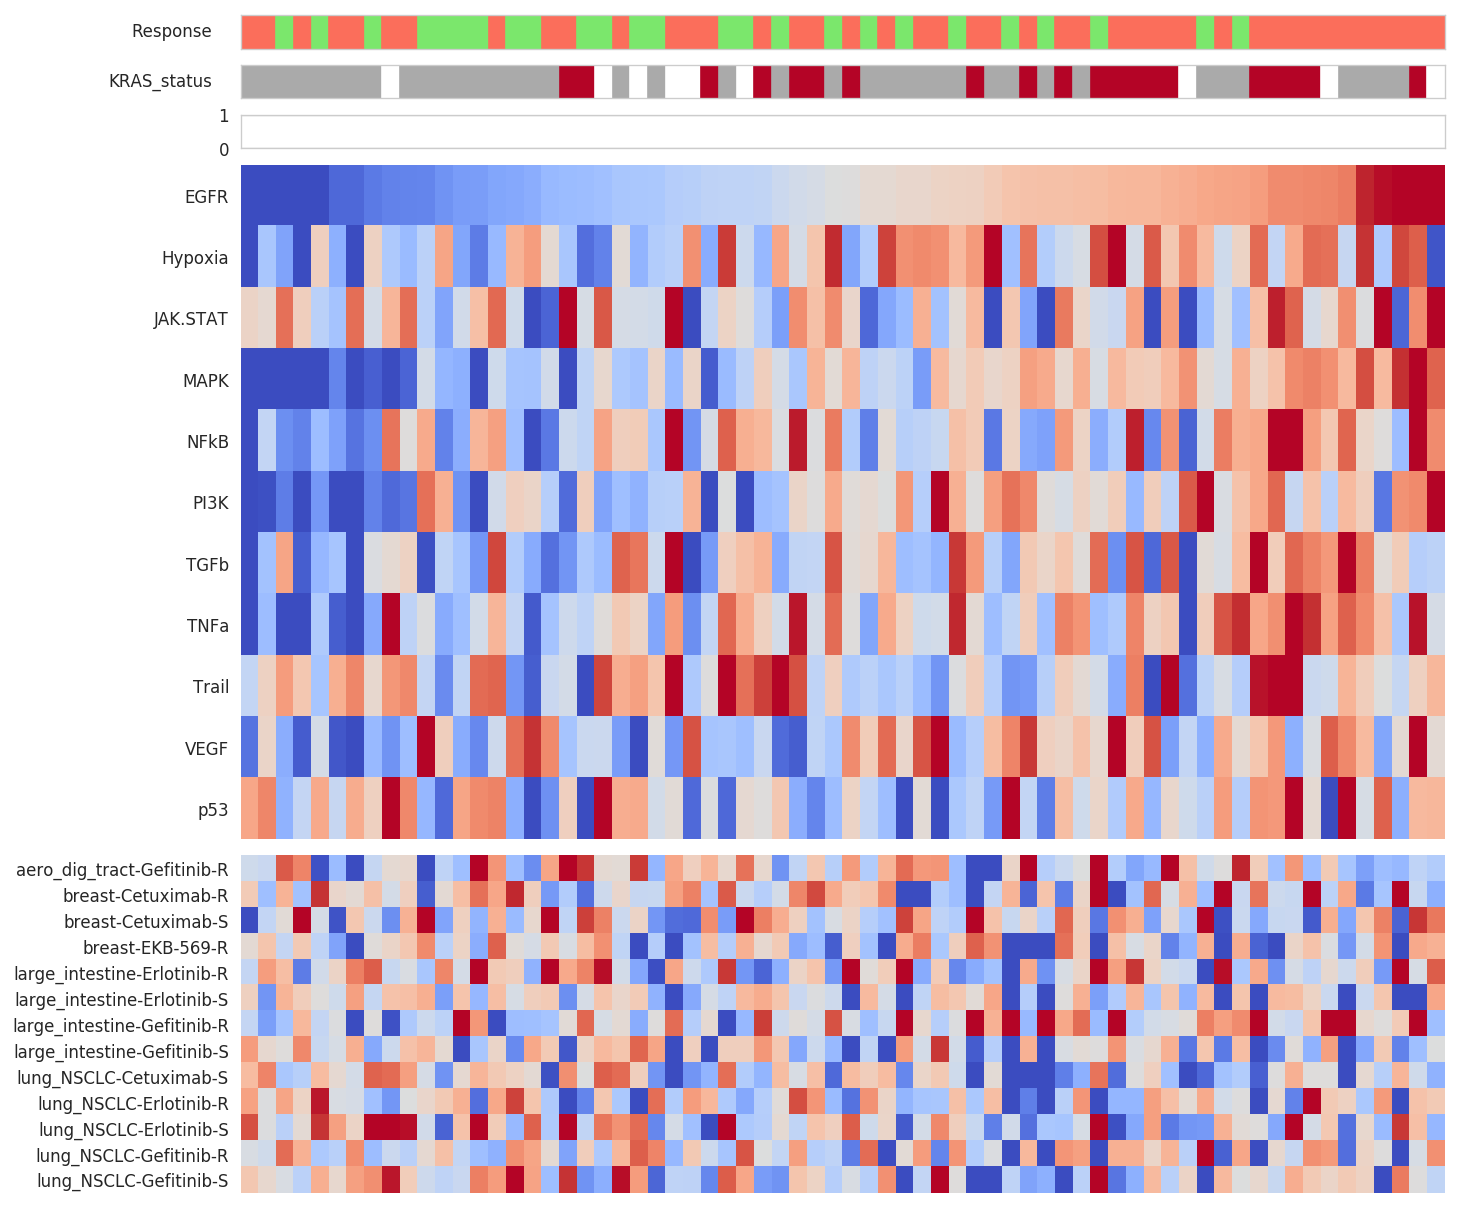

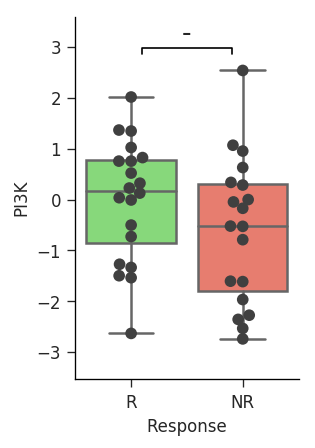

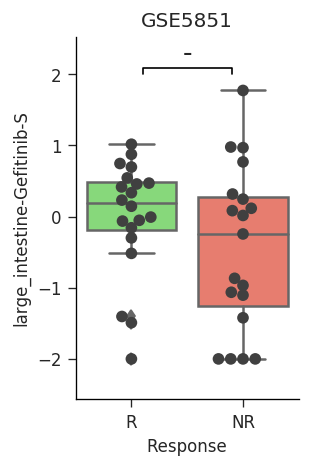

GSE33072 NSCLC Erlotinib/sorafenib (131, 23)


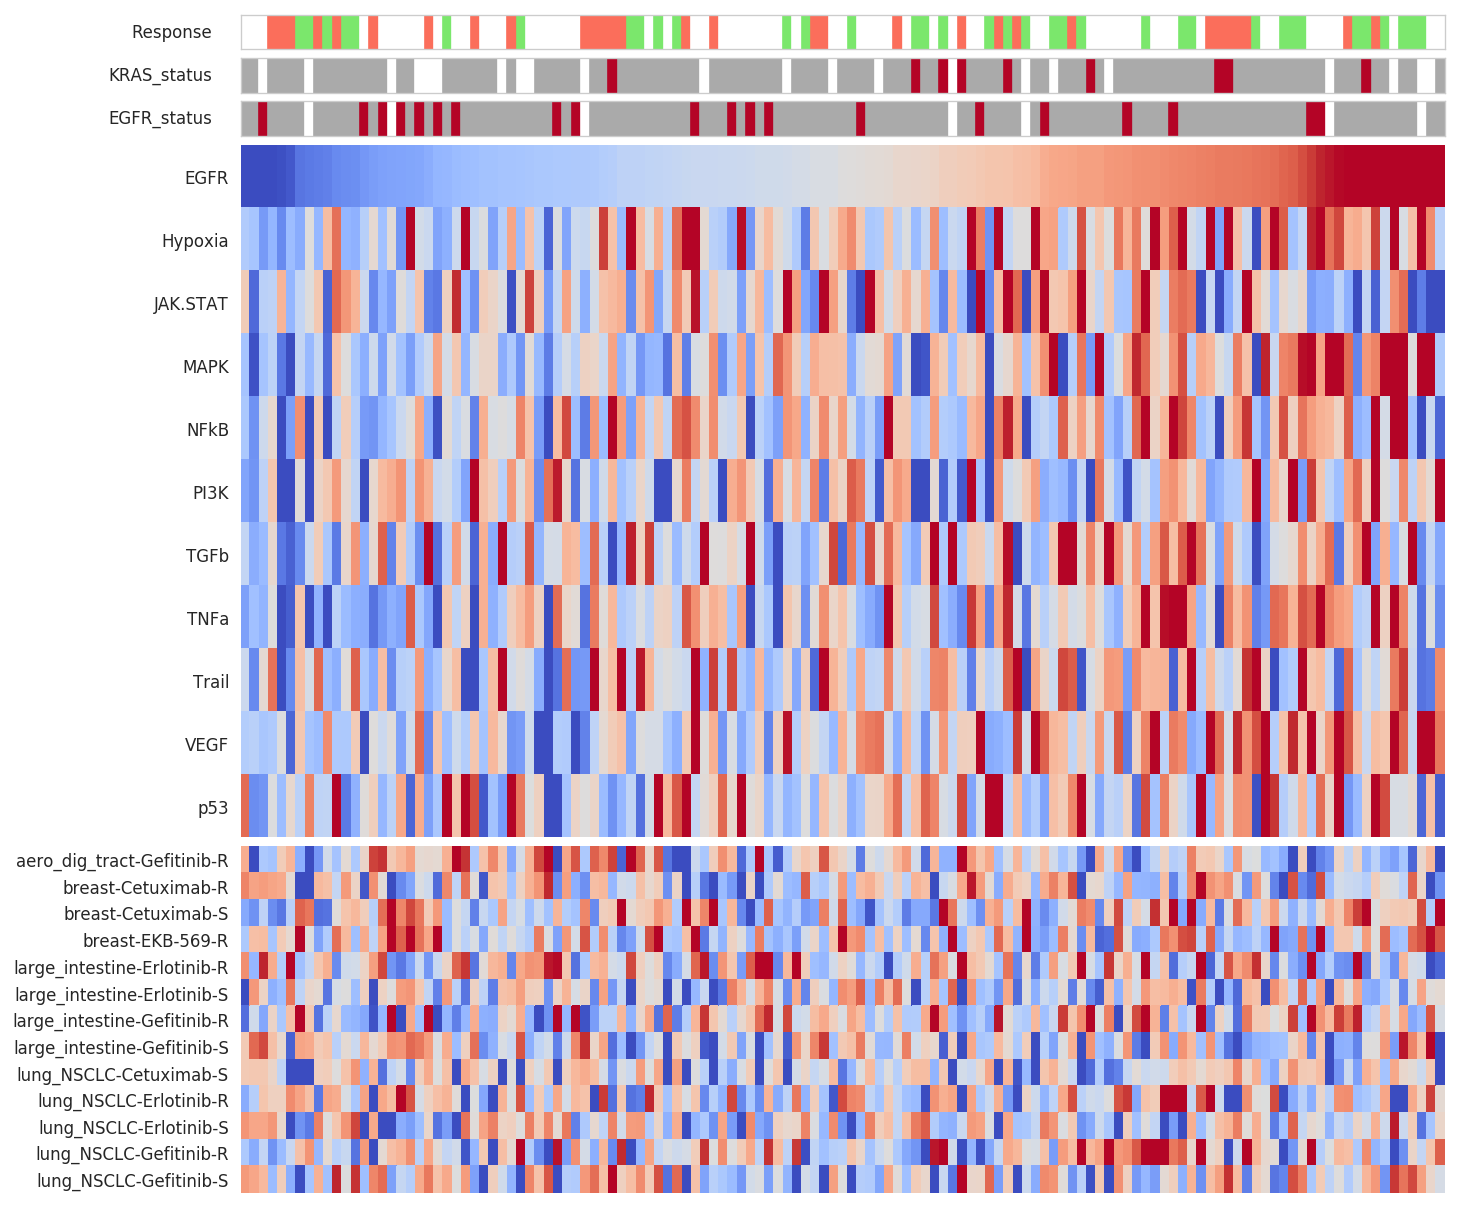

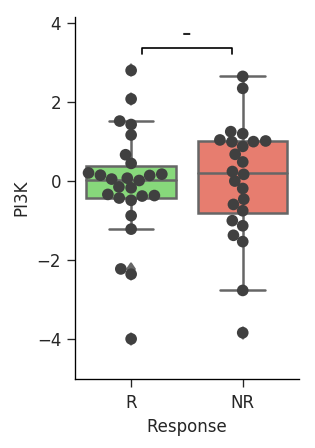

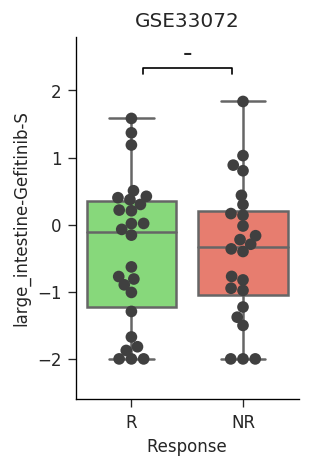

GSE37138 NSCLC Erlotinib+bevacizumab (42, 17)


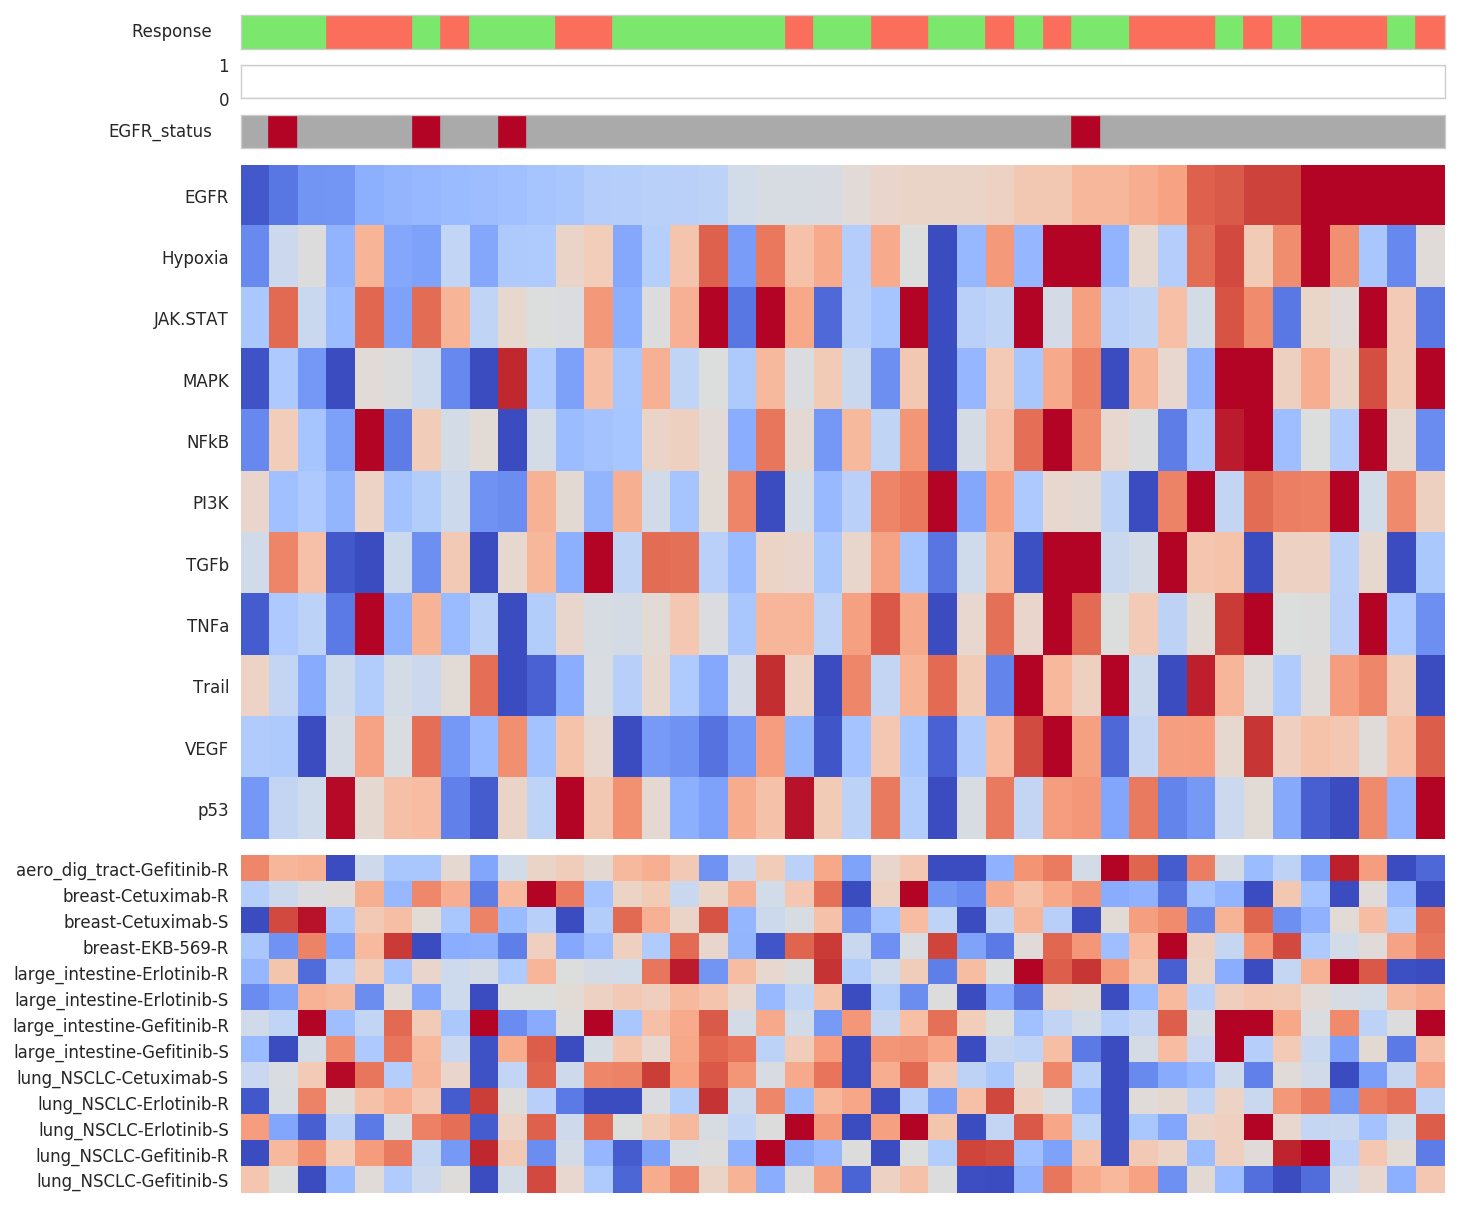

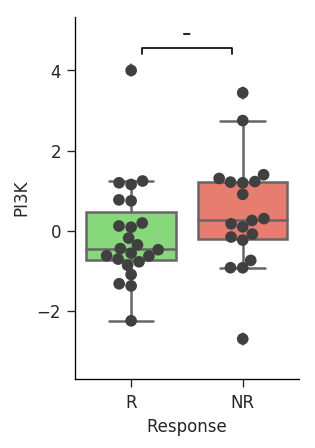

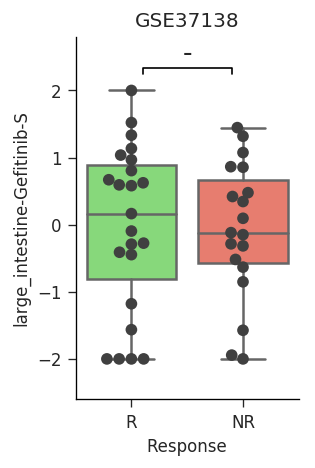

GSE65021 HNSCC Cetuximab (40, 10)


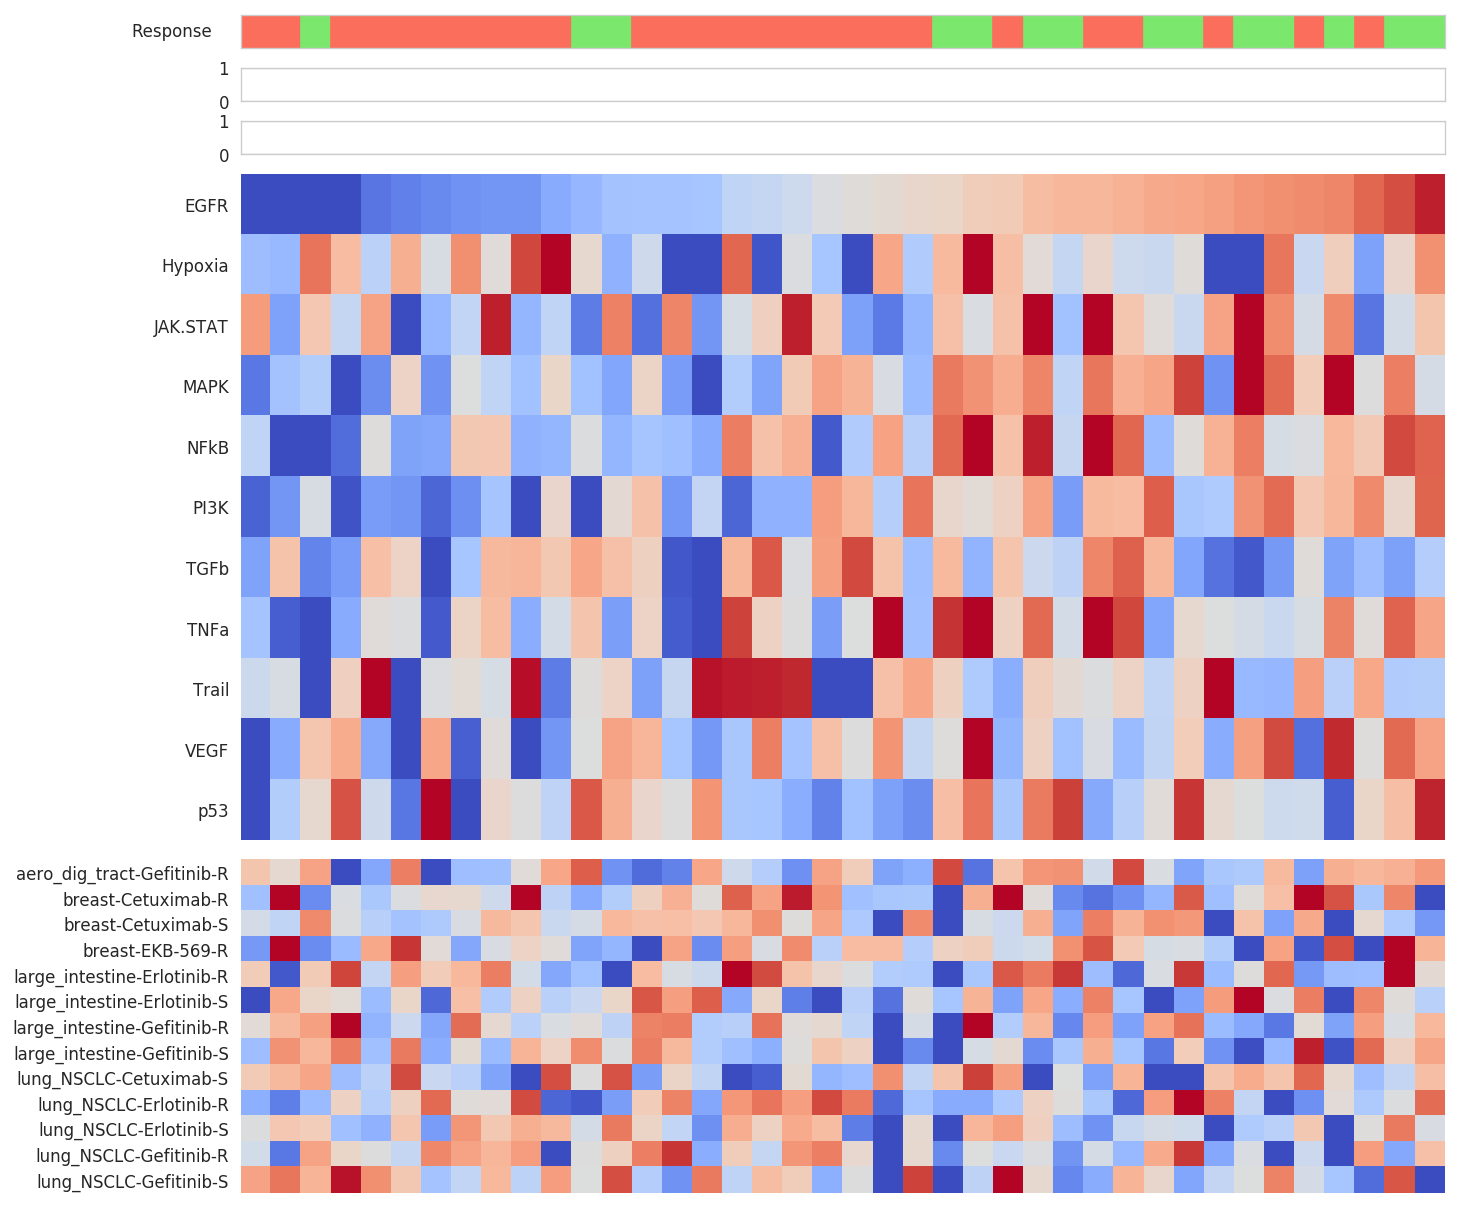

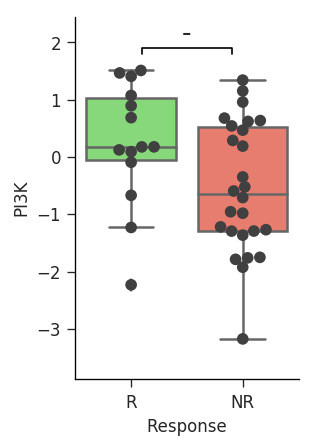

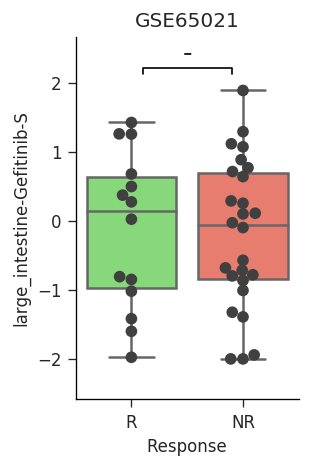

GSE76360 BRCA Trastuzumab (100, 14)


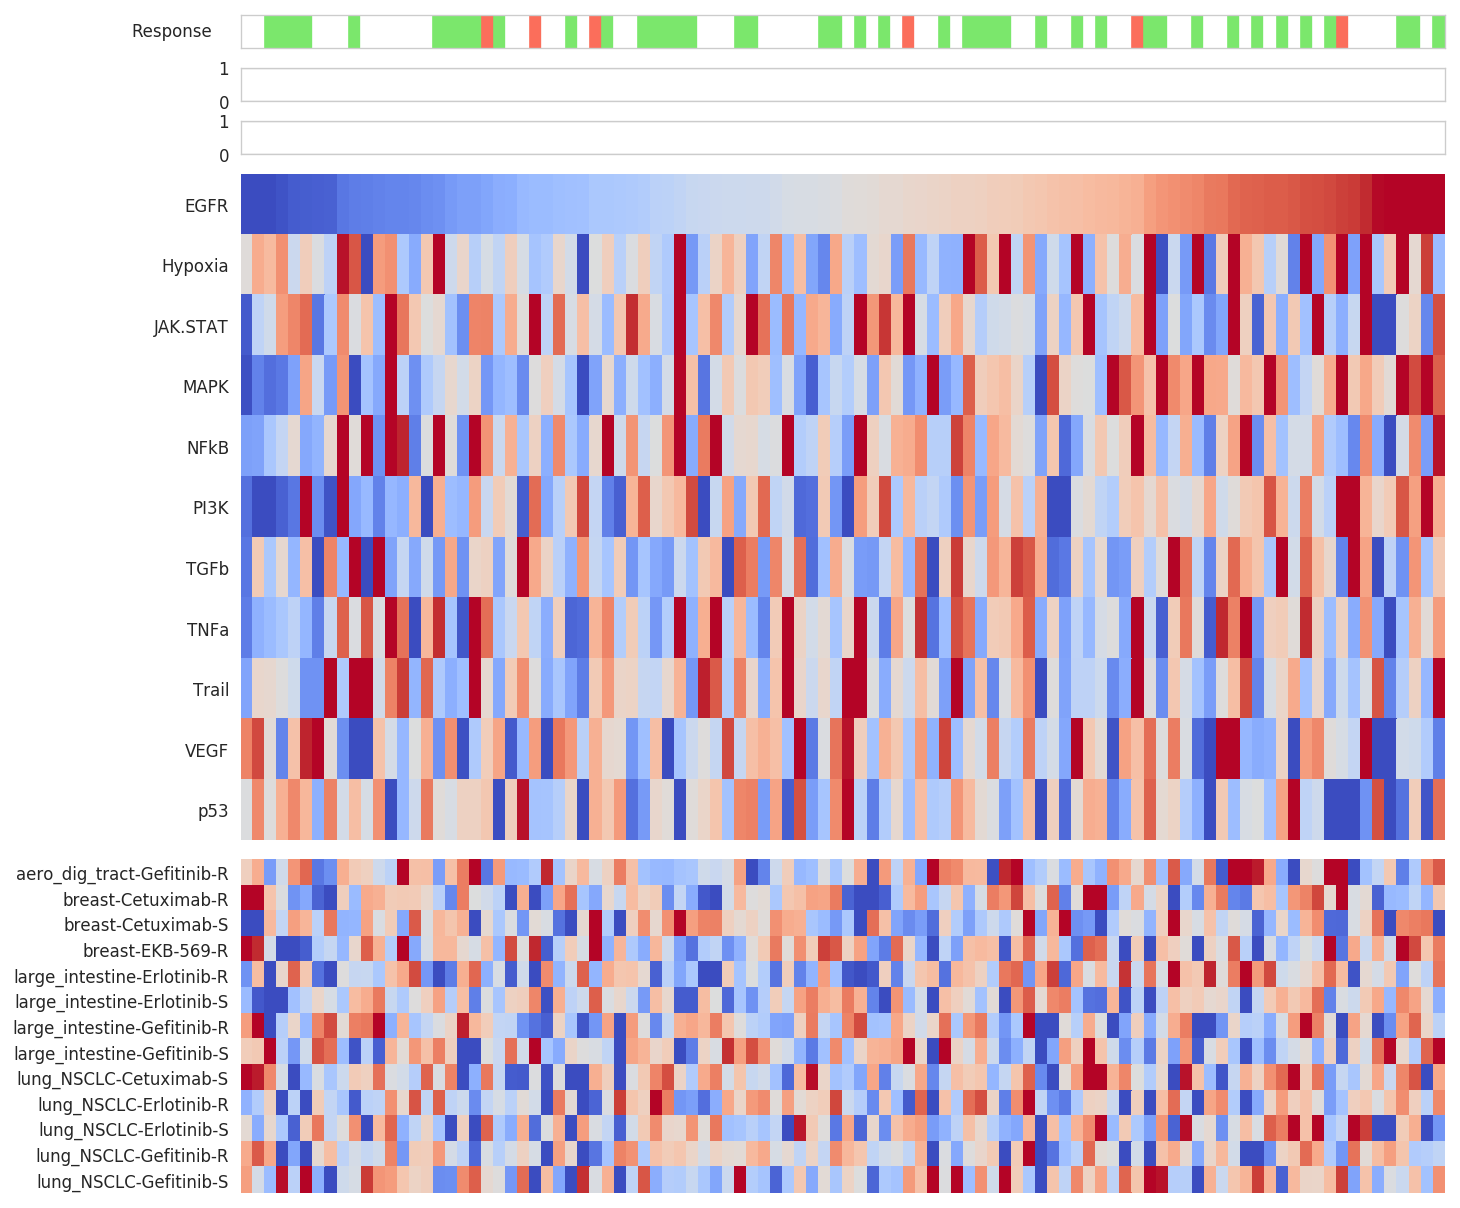

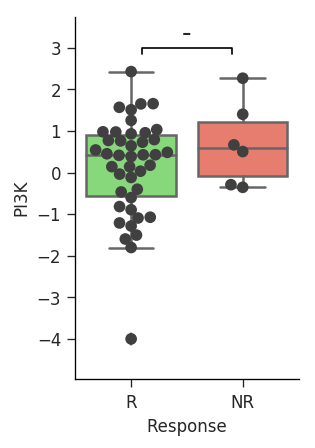

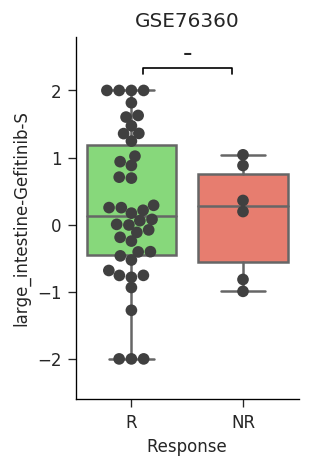

GSE47994 BRCA Trastuzumab (335, 21)


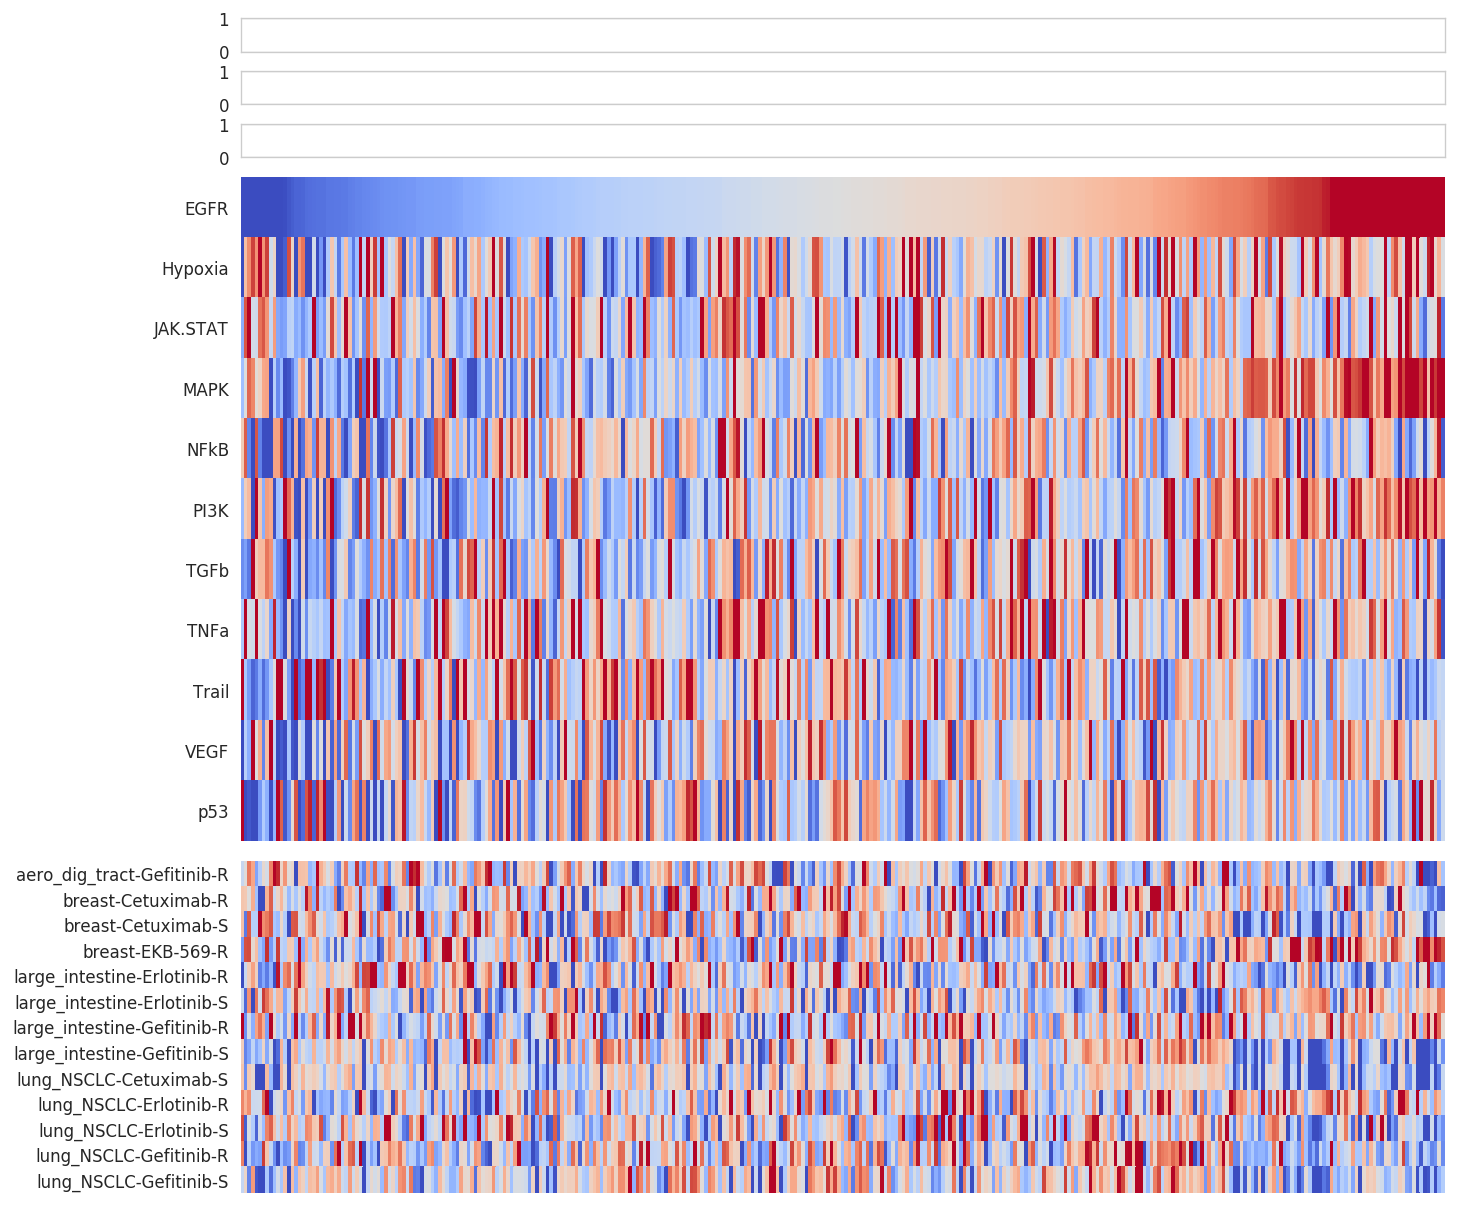

GSE55348 BRCA Trastuzumab (53, 15)


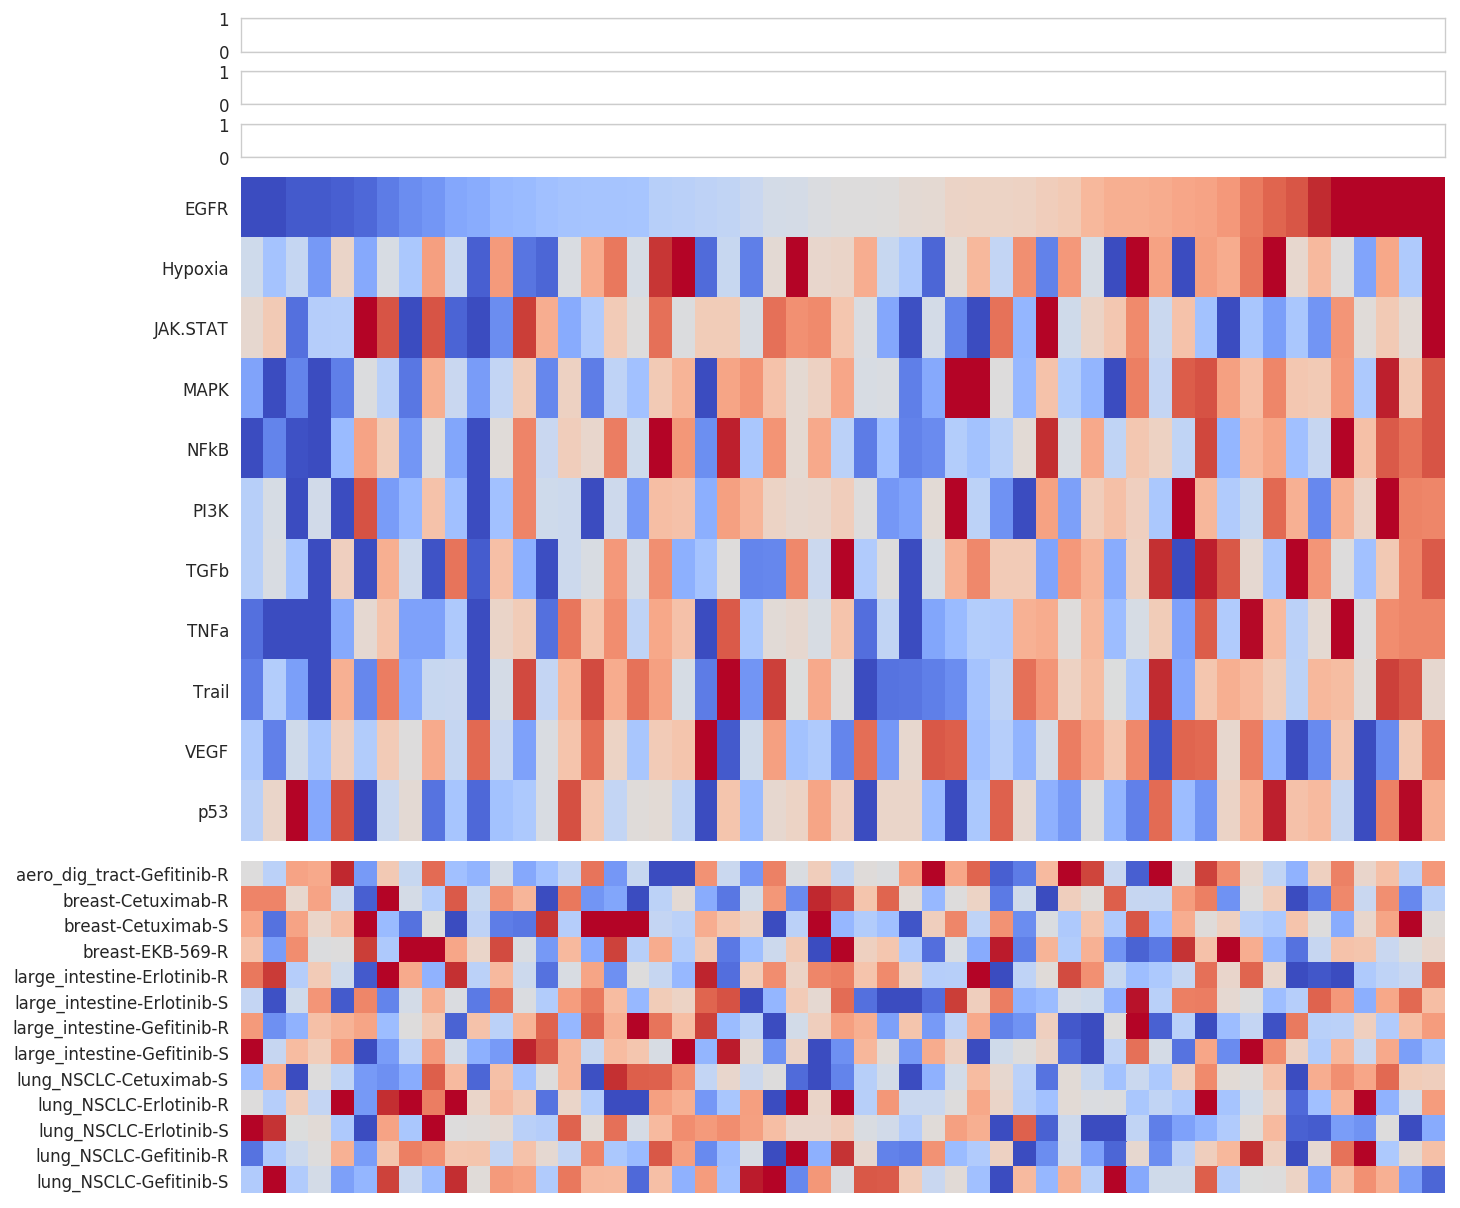

GSE62327 BRCA Trastuzumab (24, 11)


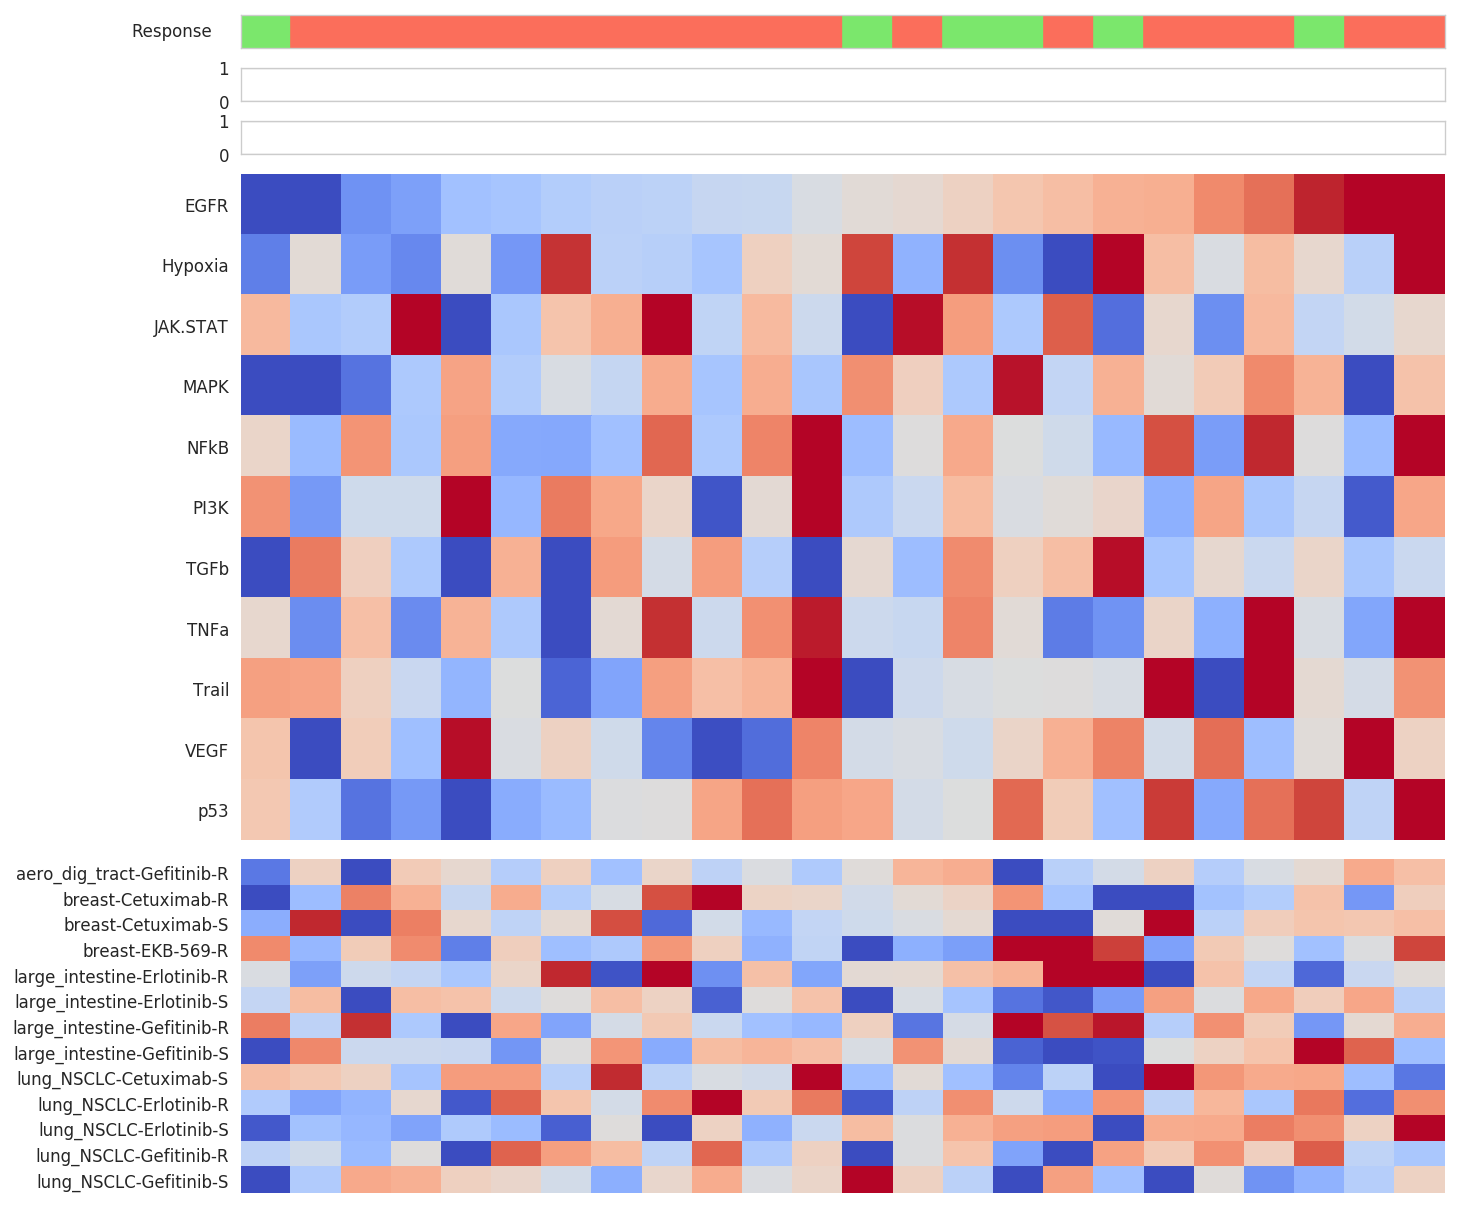

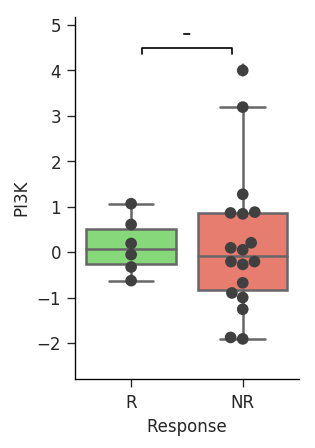

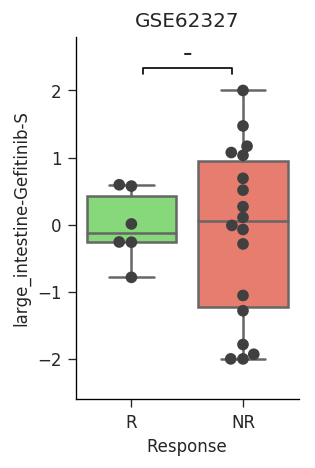

GSE58984 BRCA Trastuzumab (94, 17)


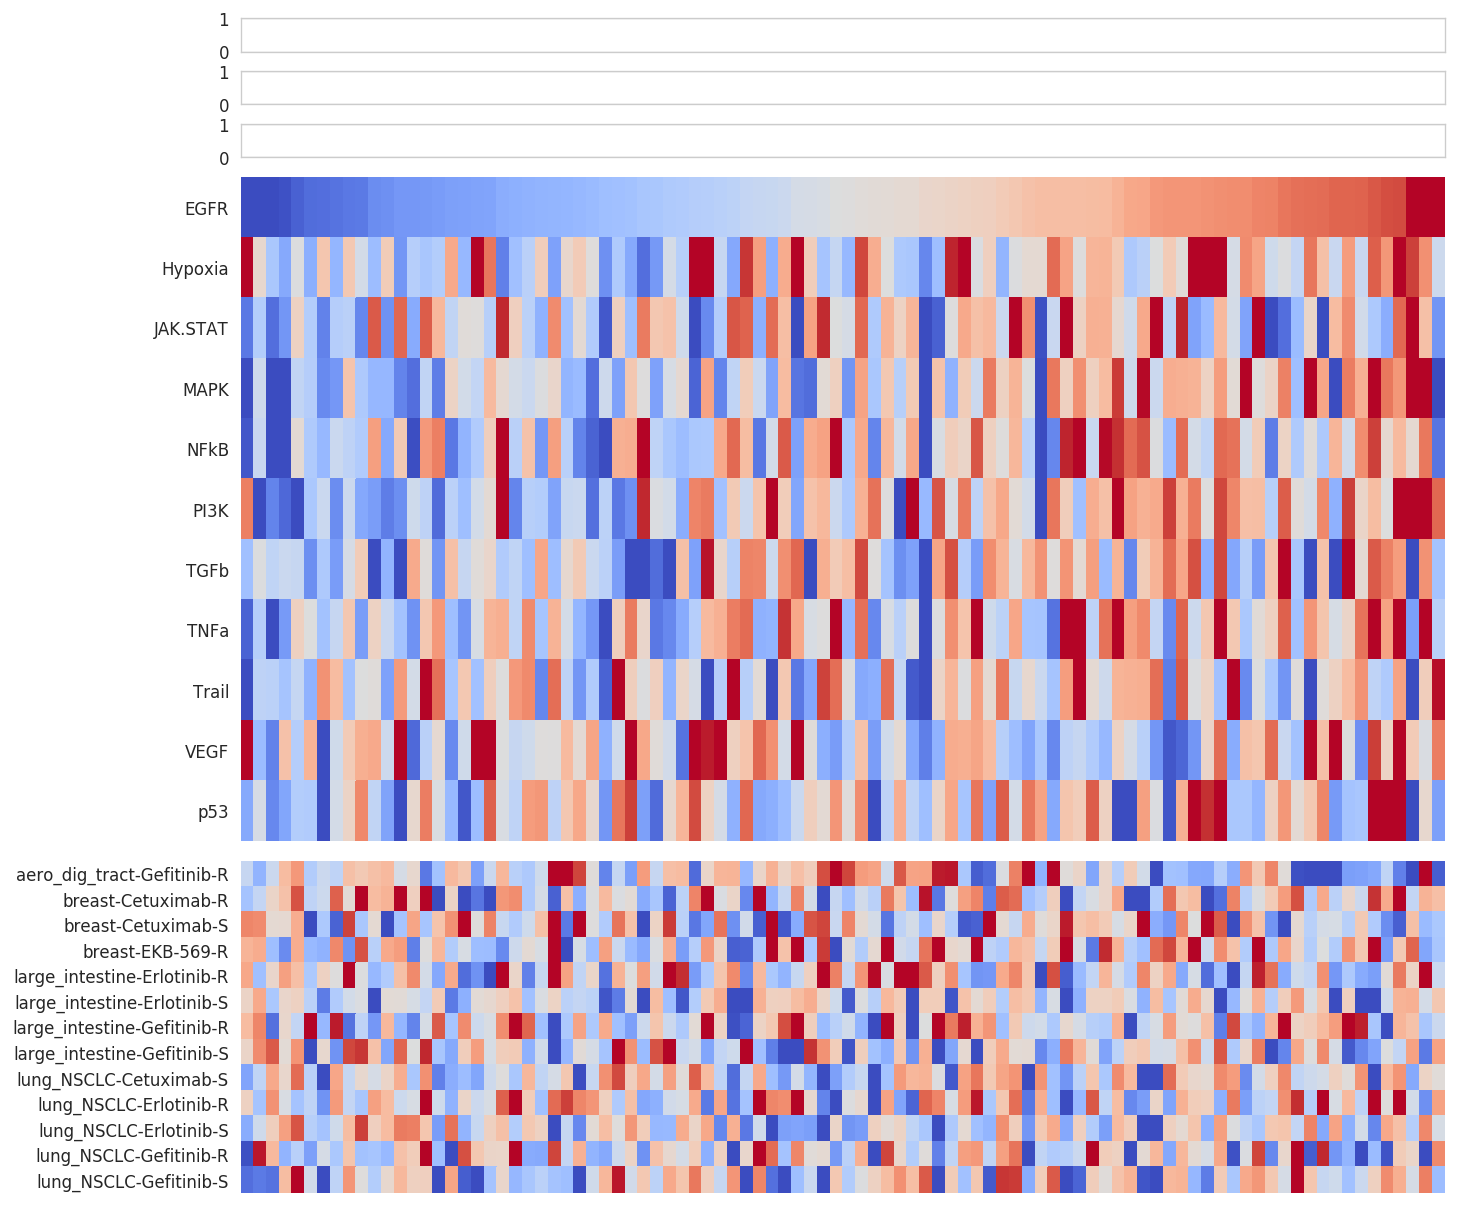

In [152]:
for cds in datasets:
    print(cds, datasets_annotation.Cancer[cds], datasets_annotation.Drug[cds], ann_d[cds].shape)
    
    cann = ann_d[cds]
    cprogeny = progeny_d[cds]
    
    
    so = cprogeny.EGFR.sort_values().index


    af = axis_matras([.3, .3, .3, 6, 3], x_len=12)

    ax = next(af)
    if 'Response' in cann:
        line_palette_annotation_plot(cann.Response[so], response_palette, ax=ax)

    ax = next(af)
    if 'KRAS_status' in cann:
        line_palette_annotation_plot(cann.KRAS_status[so], {'WT': lgrey_color, 
                                                              'MUT': red_color}, ax=ax)
    ax = next(af)
    if 'EGFR_status' in cann:
        line_palette_annotation_plot(cann.EGFR_status[so], {'WT': lgrey_color, 
                                                              'MUT': red_color}, ax=ax)

    ax = next(af)
    sns.heatmap(cprogeny.loc[so].clip(-2, 2).T, ax=ax, cbar=False, cmap=default_cmap, yticklabels=True, xticklabels=True)
    ax = next(af)
    sns.heatmap(signs[cds].clip(-2, 2).T, ax=ax, cbar=False, cmap=default_cmap, yticklabels=True, xticklabels=False)
    
    
    plt.tight_layout(pad=.1)
    plt.show()
    
    if 'Response' in cann:
        if 'KRAS_status' in cann:
            so = sort_by_terms_order(cann.KRAS_status, ['WT'])
        boxplot_with_pvalue(cprogeny.PI3K[so], cann.Response[so], palette=response_palette, order=['R', 'NR'])
        plt.show()
        boxplot_with_pvalue(signs[cds]['large_intestine-Gefitinib-S'], 
                            cann.Response[so], palette=response_palette, order=['R', 'NR'], 
                           title=cds)
        plt.show()

#         af = axis_net(5, 2)
#         for cs, ax in zip(cprogeny, af):
#             boxplot_with_pvalue(cprogeny[cs], cann.Response, palette=response_palette, order=['R', 'NR'], ax=ax)
#         plt.show()

GSE5851 COREAD Cetuximab (68, 23)
Iteration 1: norm_delta = 1.49200, step_size = 0.9500, ll = -184.53383, newton_decrement = 9.20449, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.18257, step_size = 0.9500, ll = -175.75702, newton_decrement = 0.21353, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01192, step_size = 0.9500, ll = -175.54342, newton_decrement = 0.00081, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00065, step_size = 1.0000, ll = -175.54261, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -175.54261, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 59 observations, 0 censored>
      duration col = 'duration'
         event col = 'events'
number of subjects = 59
  number of events = 59
    log-likelihood = -175.54
  time fit was run = 2019-03-03 10:52:10 UTC

---
          coef  exp(coef)  se(coef)     

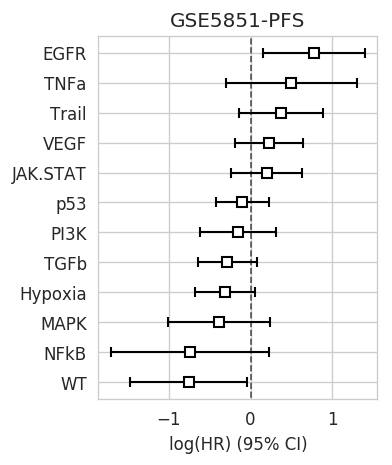

GSE33072 NSCLC Erlotinib/sorafenib (131, 23)
Iteration 1: norm_delta = 0.87794, step_size = 0.9500, ll = -174.79333, newton_decrement = 10.56328, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.17678, step_size = 0.9500, ll = -164.33651, newton_decrement = 0.18387, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00777, step_size = 0.9500, ll = -164.15349, newton_decrement = 0.00052, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00042, step_size = 1.0000, ll = -164.15297, newton_decrement = 0.00000, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -164.15297, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 58 observations, 3 censored>
      duration col = 'duration'
         event col = 'events'
number of subjects = 58
  number of events = 55
    log-likelihood = -164.15
  time fit was run = 2019-03-03 10:52:10 UTC

---
          coef  exp(coef)  s

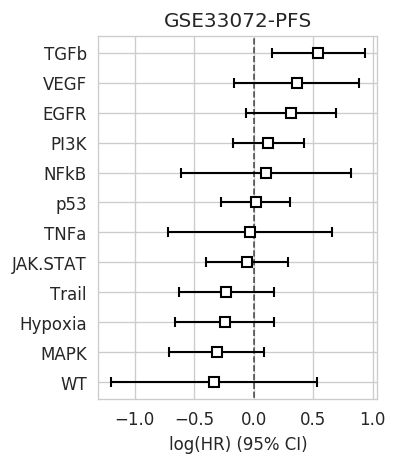

GSE37138 NSCLC Erlotinib+bevacizumab (42, 17)
GSE65021 HNSCC Cetuximab (40, 10)
GSE76360 BRCA Trastuzumab (100, 14)
GSE47994 BRCA Trastuzumab (335, 21)
Iteration 1: norm_delta = 0.54073, step_size = 0.9500, ll = -1316.03501, newton_decrement = 12.79959, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.02175, step_size = 0.9500, ll = -1303.67584, newton_decrement = 0.06156, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00118, step_size = 0.9500, ll = -1303.61420, newton_decrement = 0.00020, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00006, step_size = 1.0000, ll = -1303.61401, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -1303.61401, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 335 observations, 53 censored>
      duration col = 'duration'
         event col = 'events'
number of subjects = 335
  number of even

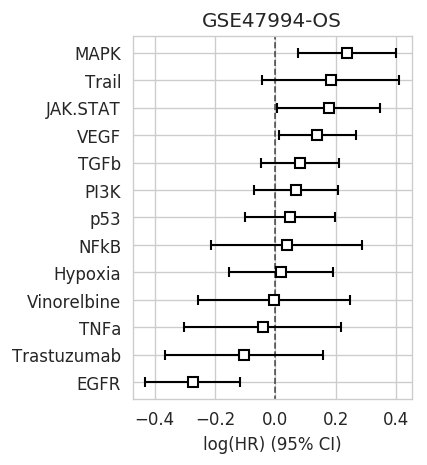

Iteration 1: norm_delta = 0.57329, step_size = 0.9500, ll = -1165.41924, newton_decrement = 13.54343, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.02751, step_size = 0.9500, ll = -1152.28579, newton_decrement = 0.07920, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00153, step_size = 0.9500, ll = -1152.20646, newton_decrement = 0.00026, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00008, step_size = 1.0000, ll = -1152.20620, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -1152.20620, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 335 observations, 80 censored>
      duration col = 'duration'
         event col = 'events'
number of subjects = 335
  number of events = 255
    log-likelihood = -1152.21
  time fit was run = 2019-03-03 10:52:10 UTC

---
             coef  exp(coef)  se(coef)     z      p  -log2(p)  

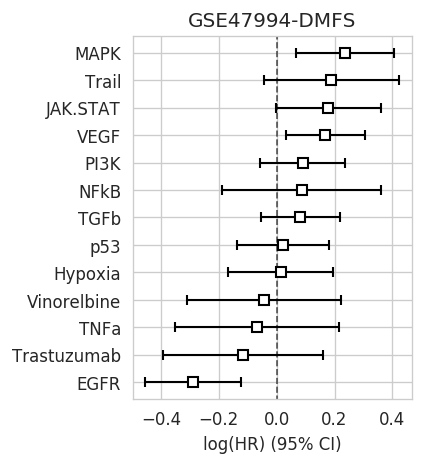

GSE55348 BRCA Trastuzumab (53, 15)
Iteration 1: norm_delta = 1.34709, step_size = 0.9500, ll = -80.13359, newton_decrement = 10.01820, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.31202, step_size = 0.9500, ll = -70.57382, newton_decrement = 0.47891, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03466, step_size = 0.9500, ll = -70.09695, newton_decrement = 0.00300, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00212, step_size = 1.0000, ll = -70.09395, newton_decrement = 0.00001, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -70.09394, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 53 observations, 30 censored>
      duration col = 'duration'
         event col = 'events'
number of subjects = 53
  number of events = 23
    log-likelihood = -70.09
  time fit was run = 2019-03-03 10:52:11 UTC

---
          coef  exp(coef)  se(coef)     z  

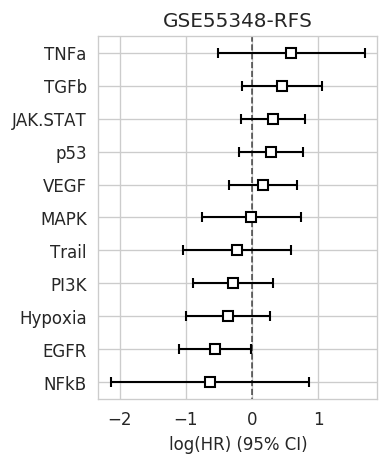

GSE62327 BRCA Trastuzumab (24, 11)
GSE58984 BRCA Trastuzumab (94, 17)
Iteration 1: norm_delta = 1.32261, step_size = 0.9500, ll = -47.71912, newton_decrement = 6.52420, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.72792, step_size = 0.9500, ll = -40.78404, newton_decrement = 0.76696, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.12997, step_size = 0.9500, ll = -39.98097, newton_decrement = 0.02271, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.01266, step_size = 1.0000, ll = -39.95786, newton_decrement = 0.00017, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00005, step_size = 1.0000, ll = -39.95769, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 94 observations, 83 censored>
      duration col = 'duration'
         event col = 'events'
number of subjects = 94
  number of events = 11
    log-likelihood = -39.96
  time fit was run = 2019-03-03 10:52:11 UTC

---
         

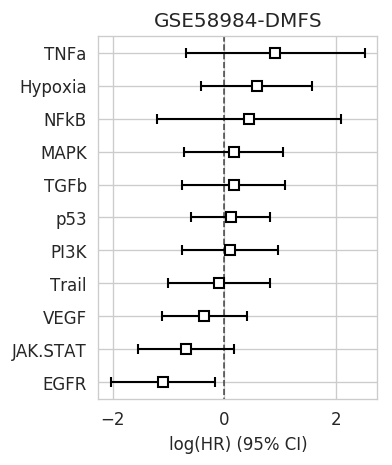

In [157]:
for cds in datasets:
    print(cds, datasets_annotation.Cancer[cds], datasets_annotation.Drug[cds], ann_d[cds].shape)
    
    for to_name, to_name_f in zip(['OS', 'PFS', 'DMFS', 'RFS'], ['Dead', 'PFS_Flag', 'DMFS_Flag', 'RFS_Flag']):
        if to_name in ann_d[cds]:
            
            fs = prepare_survival_annotation(ann_d[cds][to_name], ann_d[cds][to_name_f])

            categorical_list = []
            numerical_list=[progeny_d[cds].clip(-2, 2),# median_scale(ann_d.Age, 2)
#                             median_scale(exp_d[cds].VIM),
#                                         signs[cds]
                                                   ]
            if 'KRAS_status' in ann_d[cds]:
                categorical_list.append(ann_d[cds]['KRAS_status'])
            if  cds == 'GSE47994' :
                categorical_list.append(ann_d[cds]['Drug'])
            if cds == 'GSE47994' :
                categorical_list.append(ann_d[cds]['Chemotherapy_regimen'])
                
#             if 'EGFR_status' in ann_d[cds]:
#                 categorical_list.append(ann_d[cds]['EGFR_status'])


            cph = simple_multivar_cox_reg(fs, categorical_list=categorical_list, 
                                    numerical_list=numerical_list)
            ax = axis_net(1,1, y_len=4, x_len=3)
            cph.plot(ax=ax)
            ax.set_title('{}-{}'.format(cds, to_name))
            plt.show()

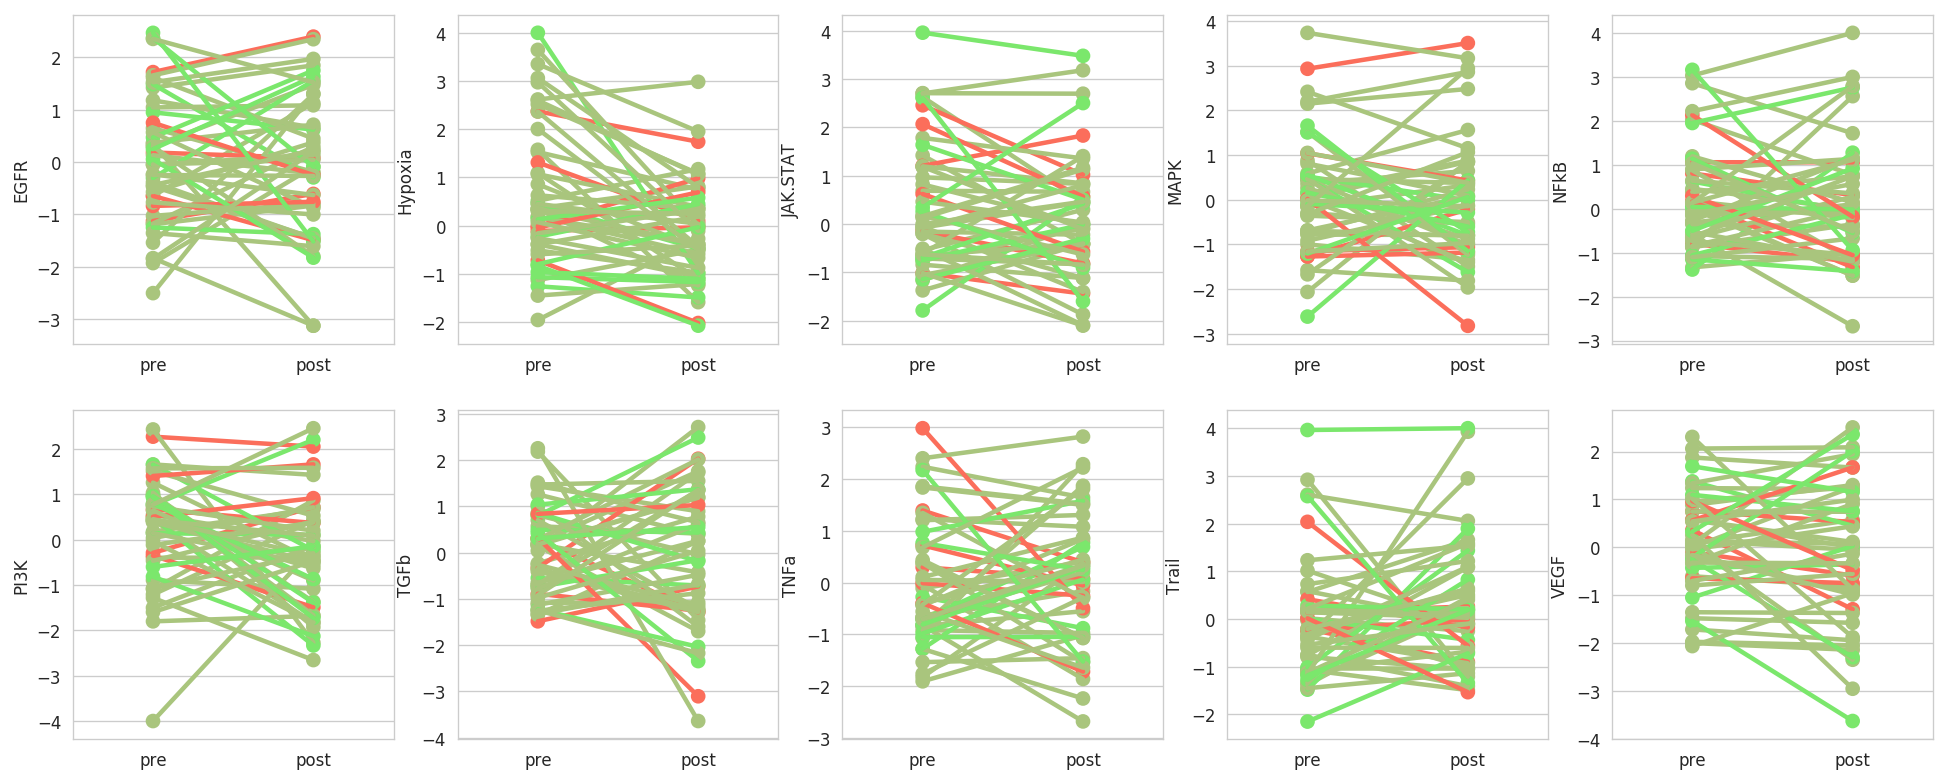

In [113]:
cds = 'GSE76360'
ccol = ann_d[cds].set_index('Patient').Recist.dropna().map(recist_palette)
so = sort_by_terms_order(ann_d[cds].Patient, ccol.index)
af = axis_net(5, 2)
for cs, ax in zip(progeny_d[cds], af):
    progression_plot(progeny_d[cds][cs][so], ann_d[cds].Patient[so], 
                     ann_d[cds].Time, color=ccol, 
                     order=['pre', 'post'], ax=ax)
plt.show()